# ANL11-A2: IAEA 2D PWR
This notebook implements a steady neutron diffusion equation on the ANL11-A2 benchmark, also referred to as [IAEA benchmark](https://inis.iaea.org/search/search.aspx?orig_q=RN:9397189) using the [FEniCSx library](https://fenicsproject.org).

In [2]:
from dolfinx.io import gmshio
import gmsh
from mpi4py import MPI

import numpy as np
import pandas as pd
from ufl import Measure
from IPython.display import clear_output

import matplotlib.pyplot as plt
from matplotlib import cm

import sys

mesh_path      = '../../../mesh/'
benchmark_path = '../../../BenchmarkData/'

sys.path.append('../../../models/fenicsx')

## Preamble
The geometry and the main physical parameters will be assigned.

### Mesh Import
The geometry and the mesh are imported from "ANL11-A2_octave.msh", generated with GMSH.

In [3]:
gdim = 2
model_rank = 0
mesh_comm = MPI.COMM_WORLD

mesh_factor = .75

# Initialize the gmsh module
gmsh.initialize()

# Load the .geo file
gmsh.merge(mesh_path+'ANL11-A2_octave.geo')
gmsh.model.geo.synchronize()

gmsh.option.setNumber("Mesh.MeshSizeFactor", mesh_factor)

gmsh.model.mesh.generate(gdim)
gmsh.model.mesh.optimize("Netgen")
clear_output()

# Domain
domain, ct, ft = gmshio.model_to_mesh(gmsh.model, comm = mesh_comm, rank = model_rank, gdim = gdim )
gmsh.finalize()
    
domain1_marker = 10
domain2_marker = 20
domain3_marker = 30
domain4_marker = 40

boundary_marker = 1

tdim = domain.topology.dim
fdim = tdim - 1

ds = Measure("ds", domain=domain, subdomain_data=ft)
dx = Measure("dx", domain=domain)

domain.topology.create_connectivity(fdim, tdim)

### Define parameter functions on the different regions
Since there are 4 subdomains in $\Omega$ (i.e., fuel-1, fuel-2, fuel-rod, reflector) the values of the parameters changes according to the region, therefore proper functions should be defined.

In [4]:
regions = [domain1_marker, domain2_marker, domain3_marker, domain4_marker]    

neutronics_param = dict()

neutronics_param['Energy Groups'] = 2

neutronics_param['D'] = [np.array([1.5, 1.5, 1.5, 2.]),
                         np.array([0.4,   0.4,    0.4,   0.3])]
neutronics_param['xs_a'] = [np.array([0.01,  0.01,   0.01,  0.]),
                            np.array([0.085,  0.08,  0.13,  0.01])]
neutronics_param['nu_xs_f'] = [np.array([0., 0., 0., 0.]),
                               np.array([0.135, 0.135,  0.135, 0.])]
neutronics_param['chi'] = [np.array([1,1,1,1]),
                           np.array([0,0,0,0])]
neutronics_param['B2z'] = [np.array([0.8e-4]*4),
                           np.array([0.8e-4]*4)]
neutronics_param['xs_s'] = [[np.array([0]*4), np.array([0.02,  0.02,   0.02,  0.04])],
                            [np.array([0]*4), np.array([0]*4)]]

nu_value = 1
Ef = 1
reactor_power = 1

albedo = [0.4692] * 2

## Solution of the eigenvalue problem
The MG diffusion equation is discretised using the Finite Element Method, and its eigenvalue formulation is solved through the standard inverse-power method.

In [6]:
from neutronics.neutr_diff import steady_neutron_diff

neutr_steady_problem = steady_neutron_diff(domain, ct, ft, neutronics_param, regions, boundary_marker, 
                                           albedo = albedo)
neutr_steady_problem.assembleForm()

# Solving transient problem
phi_ss, k_eff = neutr_steady_problem.solve(power = reactor_power, Ef=Ef, nu = nu_value, 
                                           LL = 50, maxIter = 500, verbose=True)

    Iter 050 | k_eff: 1.029513 | Rel Error: 4.444e-06
    Iter 100 | k_eff: 1.029585 | Rel Error: 2.970e-07
    Iter 150 | k_eff: 1.029591 | Rel Error: 3.668e-08
    Iter 200 | k_eff: 1.029592 | Rel Error: 5.408e-09
    Iter 250 | k_eff: 1.029592 | Rel Error: 8.227e-10
    Iter 300 | k_eff: 1.029592 | Rel Error: 1.258e-10
    Neutronics converged with 307 iter | k_eff: 1.02959182 | rho: 2874.13 pcm | Rel Error: 9.670e-11


## Post-processing
The solution of the eigenvalue problem is compared with reference data.

Let us compare the $k_{eff}$ with the benchmark value

In [7]:
print('Computed  k_eff = {:.5f}'.format(k_eff))
print('Benchmark k_eff = {:.5f}'.format(1.02959))
print('Relative error  = {:.5f}'.format(np.abs(k_eff - 1.02959) / 1.02959 * 1e5)+' pcm')

Computed  k_eff = 1.02959
Benchmark k_eff = 1.02959
Relative error  = 0.17629 pcm


Let us plot the solution against benchmark data along the diagonal $x=y$ and along the $x$-axis $y=0$.

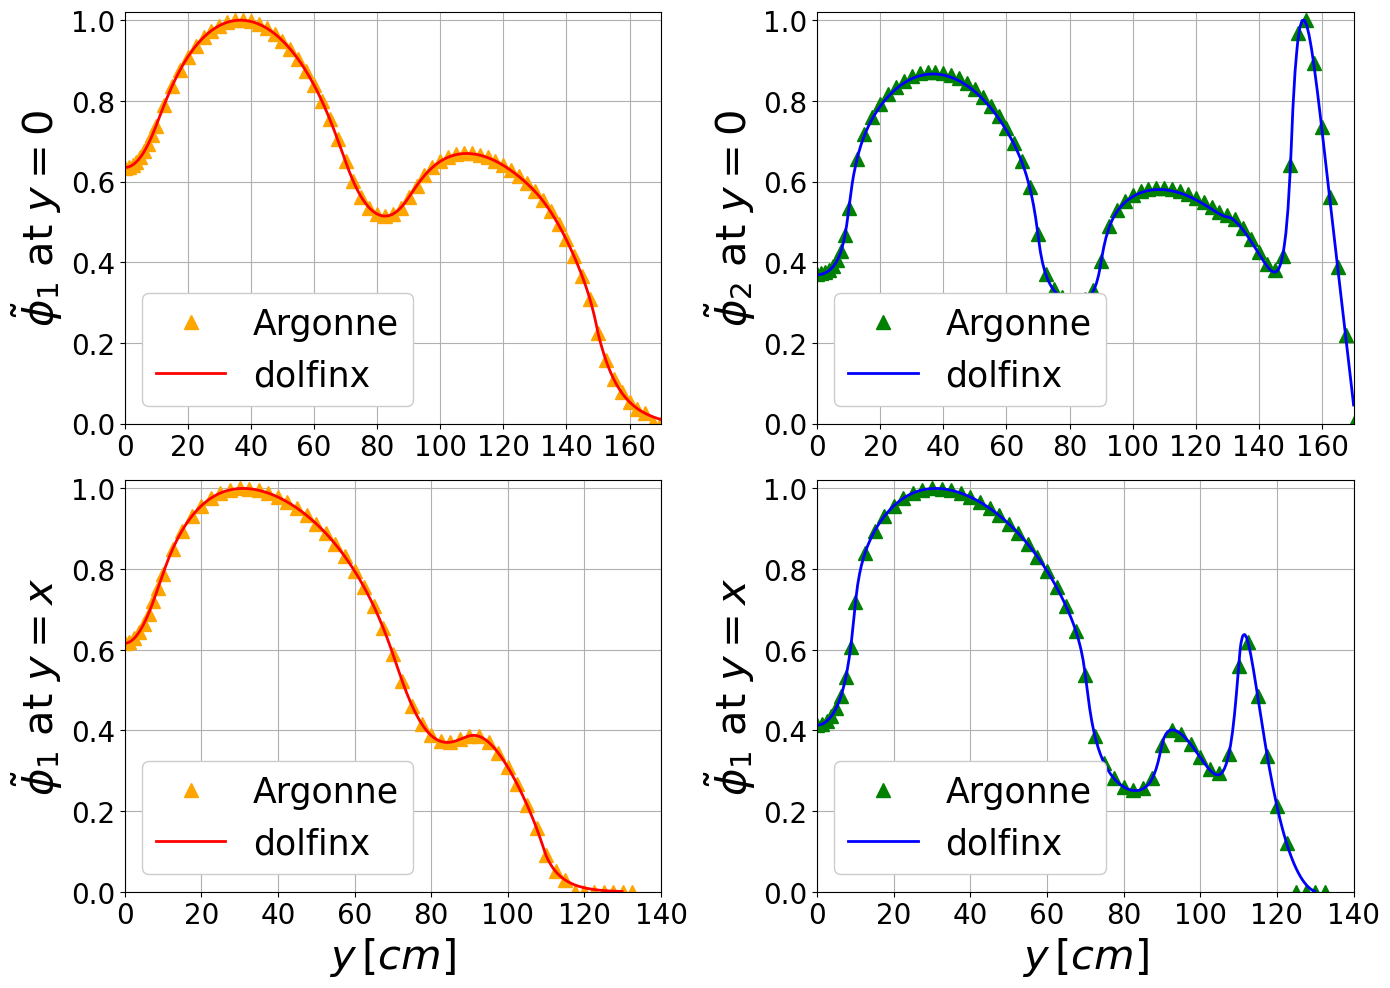

In [10]:
from plotting import extract_cells

Nhplot = 1000
xMax = 170
x_line = np.linspace(0, xMax + 1e-20, Nhplot)
points = np.zeros((3, Nhplot))
points[0] = x_line
xPlot_0, cells_0 = extract_cells(domain, points)
points[1] = x_line
xPlot_1, cells_1 = extract_cells(domain, points)

## Uploading data from benchmark
x_axis_data   = pd.read_excel(benchmark_path+'neutronics/ANL11-A2/data.xlsx', sheet_name='x-axis').to_numpy()/1000
diagonal_data = pd.read_excel(benchmark_path+'neutronics/ANL11-A2/data.xlsx', sheet_name='Diagonal').to_numpy()/1000


mark_size = 10
ls = 2
labelsize = 30
tickssize = 20
legend_size = 25

fluxFigure = plt.figure( figsize = (14,10) )

plt.subplot(2,2,1)
plt.plot(x_axis_data[:, 0], x_axis_data[:,1] / max(x_axis_data[:,1]), '^', c='orange',label = r'Argonne', markersize=mark_size)
plt.plot(xPlot_0[:,0], phi_ss[0].eval(xPlot_0, cells_0) / max(phi_ss[0].eval(xPlot_0, cells_0)), 'r', label = r'dolfinx', linewidth=ls)
  
plt.ylabel(r"$\tilde{\phi}_1$ at $y=0$",fontsize=labelsize)
plt.xticks(fontsize=tickssize)
plt.yticks(fontsize=tickssize)
plt.grid(which='major',linestyle='-')
plt.grid(which='minor',linestyle='--')
plt.legend(fontsize = legend_size, loc = 'lower left', framealpha=1)
plt.xlim(0, 170)
plt.ylim(0., 1.02)

plt.subplot(2,2,2)
plt.plot(x_axis_data[:, 0], x_axis_data[:,2] / max(x_axis_data[:,2]), '^', c='g',label = r'Argonne', markersize=mark_size)
plt.plot(xPlot_0[:,0], phi_ss[1].eval(xPlot_0, cells_0) / max(phi_ss[1].eval(xPlot_0, cells_0)), 'b', label = r'dolfinx', linewidth=ls)
  
plt.ylabel(r"$\tilde{\phi}_2$ at $y=0$",fontsize=labelsize)
plt.xticks(fontsize=tickssize)
plt.yticks(fontsize=tickssize)
plt.grid(which='major',linestyle='-')
plt.grid(which='minor',linestyle='--')
plt.legend(fontsize = legend_size, loc = 'lower left', framealpha=1)
plt.xlim(0, 170)
plt.ylim(0., 1.02)

plt.subplot(2,2,3)
plt.plot(diagonal_data[:, 0], diagonal_data[:,2] / max(diagonal_data[:,2]), '^', c='orange',label = r'Argonne', markersize=mark_size)
plt.plot(xPlot_1[:,0], phi_ss[0].eval(xPlot_1, cells_1) / max(phi_ss[0].eval(xPlot_1, cells_1)), 'r', label = r'dolfinx', linewidth=ls)
  
plt.xlabel(r"$y\,[cm]$",fontsize=labelsize)
plt.ylabel(r"$\tilde{\phi}_1$ at $y=x$",fontsize=labelsize)
plt.xticks(fontsize=tickssize)
plt.yticks(fontsize=tickssize)
plt.grid(which='major',linestyle='-')
plt.grid(which='minor',linestyle='--')
plt.legend(fontsize = legend_size, loc = 'lower left', framealpha=1)
plt.xlim(0, 140)
plt.ylim(0., 1.02)

plt.subplot(2,2,4)
plt.plot(diagonal_data[:, 0], diagonal_data[:,3] / max(diagonal_data[:,3]), '^', c='g',label = r'Argonne', markersize=mark_size)
plt.plot(xPlot_1[:,0], phi_ss[1].eval(xPlot_1, cells_1) / max(phi_ss[1].eval(xPlot_1, cells_1)), 'b', label = r'dolfinx', linewidth=ls)
  
plt.xlabel(r"$y\,[cm]$",fontsize=labelsize)
plt.ylabel(r"$\tilde{\phi}_1$ at $y=x$",fontsize=labelsize)
plt.xticks(fontsize=tickssize)
plt.yticks(fontsize=tickssize)
plt.grid(which='major',linestyle='-')
plt.grid(which='minor',linestyle='--')
plt.legend(fontsize = legend_size, loc = 'lower left', framealpha=1)
plt.xlim(0, 140)
plt.ylim(0., 1.02)

plt.tight_layout()

Let us know display the fluxes contour plots.

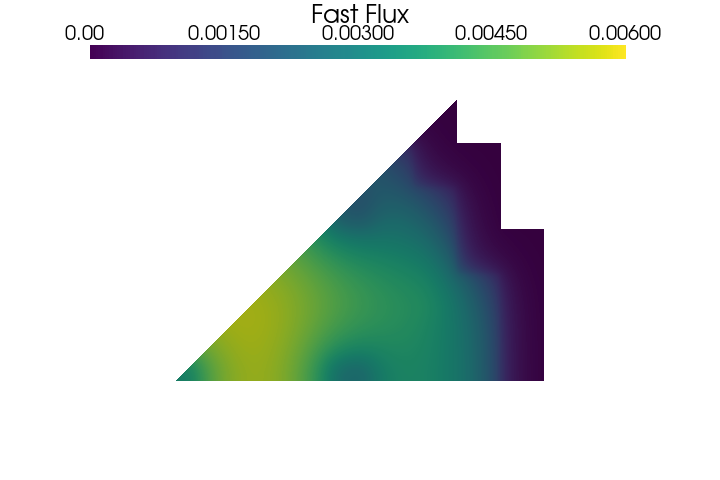

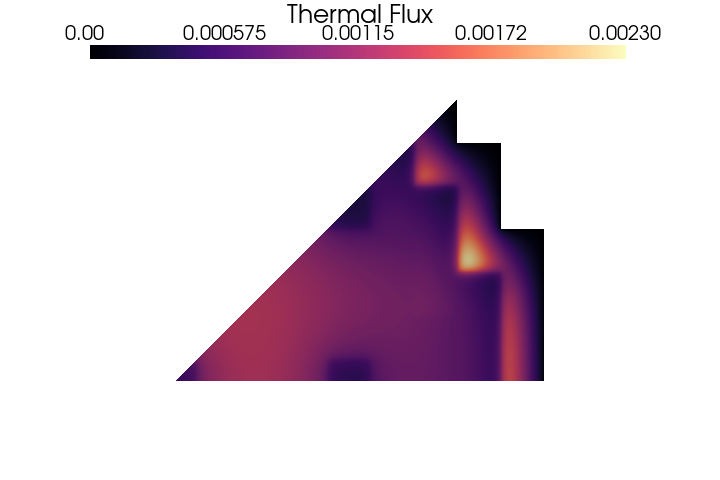

In [11]:
from plotting import PlotScalar

import warnings
warnings.filterwarnings("ignore")

PlotScalar(phi_ss[0], show=True, varname='Fast Flux', resolution=[720, 480], clim=[0, 0.006], colormap=cm.viridis)
PlotScalar(phi_ss[1], show=True, varname='Thermal Flux', resolution=[720, 480], clim=[0, 0.0023], colormap=cm.magma)

In [8]:
import pyvista as pv
from plotting import get_scalar_grid
from dolfinx.fem import Function

def subPlot_flux(fast: Function, thermal: Function,
                 filename: str = None, clim = None, 
                 cmap1 = cm.viridis, cmap2 = cm.magma, resolution = [1400, 600]):

    plotter = pv.Plotter(shape=(1,2), off_screen=False, border=False, window_size=resolution)
    
    lab_fontsize = 20
    title_fontsize = 25
    zoom = 1.2
    
    dict_cb = dict(title = ' ', width = 0.76,
                    title_font_size=title_fontsize,
                    label_font_size=lab_fontsize,
                    color='k',
                    position_x=0.12, position_y=0.86,
                    shadow=True) 

    clim_scale = .01
    
    ################### Fast Flux ###################
    plotter.subplot(0,0)
    if clim is None:    
        clim1 = [0,  max(fast.x.array) * (1+clim_scale)]
    dict_cb['title'] = 'Fast Flux'
    plotter.add_mesh(get_scalar_grid(fast, varname='phi1'), cmap = cmap1, clim = clim1, show_edges=False, scalar_bar_args=dict_cb)
    plotter.view_xy()
    plotter.camera.zoom(zoom)
    
    ################### Thermal Flux ###################
    plotter.subplot(0,1)
    if clim is None:
        clim2 = [0,  max(thermal.x.array) * (1+clim_scale)]
    dict_cb['title'] = 'Thermal Flux'
    plotter.add_mesh(get_scalar_grid(thermal, varname='phi2'), cmap = cmap2, clim = clim2, show_edges=False, scalar_bar_args=dict_cb)
    plotter.view_xy()
    plotter.camera.zoom(zoom)
    
    
    ###### Save figure ######
    
    plotter.set_background('white', top='white')
    plotter.screenshot(filename+'.png', transparent_background = True,  window_size=resolution)
    plotter.close()

In [9]:
# subPlot_flux(phi_ss[0], phi_ss[1], filename='anl11a2-contour')